In [1]:
import torch
import torch.tensor as tensor
import gpytorch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import warnings
from IPython.core import debugger

# Define a GP and specify hyperparameters

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_x = None
train_y = None
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
theta = model.state_dict()
print('Default hyperparameters (before softplus transformation):')
pprint(theta)
softplus_inv = lambda a: np.log(np.exp(a) - 1)
raw_noise_var = softplus_inv(0.0001)
print(nn.functional.softplus(tensor([raw_noise_var])))
raw_length_scale = softplus_inv(.25)
print('Set noise level and length scale:')
theta['likelihood.noise_covar.raw_noise'].data.fill_(raw_noise_var)
theta['covar_module.base_kernel.raw_lengthscale'].data.fill_(raw_length_scale)
pprint(theta)
print(model.covar_module.base_kernel.lengthscale.item())
print(model.likelihood.noise.item())


Default hyperparameters (before softplus transformation):
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[0.]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])
tensor([0.0001])
Set noise level and length scale:
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[-9.2103]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2587]]))])
0.25
0.00020000003860332072


# Draw a sample from the prior GP and posterior GP

tensor([-0.9901, -0.7887, -0.5057, -0.1767,  0.1780,  0.5364,  0.8898,  1.2066,
         1.4732,  1.6982,  1.8465,  1.9212,  1.9323,  1.8812,  1.7767,  1.6360,
         1.4804,  1.3282,  1.1797,  1.0442,  0.9180,  0.7846,  0.6498,  0.4938,
         0.3046,  0.1015, -0.1093, -0.3155, -0.5019, -0.6450, -0.7366, -0.7580,
        -0.7186, -0.6169, -0.4571, -0.2482, -0.0245,  0.2265,  0.4795,  0.7187,
         0.9237,  1.1016,  1.2367,  1.3466,  1.4353,  1.5328,  1.6371,  1.7748,
         1.9307,  2.1009])
tensor([-0.3061,  0.3469])
tensor([ 1.3282, -0.6169])


/home/shalijiang/anaconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:41: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter} to the diagonal", RuntimeWarning)


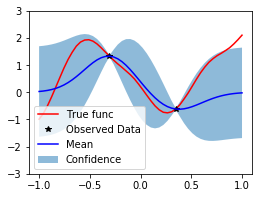

In [3]:
model.eval()
bound = 1
n = 50
x = torch.linspace(-bound,bound,n)

y_prior = model(x)
torch.manual_seed(8)
y = y_prior.sample()
print(y)

train_idx = [np.round(n/3), np.round(n*2/3)];
train_x = x[train_idx]
train_y = y[train_idx]
print(train_x)
print(train_y)
model.set_train_data(train_x, train_y, strict=False)
y_post = model(x)


with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'r')
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['True func', 'Observed Data', 'Mean', 'Confidence'])

# Define EI for minimization problem
EI(x) = sig * (z * Phi(z) +N(z)), where z = (y_best - mu(x)) / sig(x)

In [4]:
def expected_improvement(mu, sig, y_best):
    z = (y_best - mu) / sig
    standard_normal = torch.distributions.normal.Normal(loc=0, scale=1)
    # g.cdf(z) * z + torch.exp(g.log_prob(z))
    ei = sig * (z * standard_normal.cdf(z) + torch.exp(standard_normal.log_prob(z)))
    return ei

def expected_improvement_wrapper(x, gp_model, y_best):
    y_dist = gp_model(x)
    sig = torch.sqrt(y_dist.variance)
    ei_values = expected_improvement(y_dist.mean, sig, y_best)
    return ei_values

def multi_start_optim(func, num_iters=100, x_inits=None, learning_rate=0.01,  num_restarts=1, print_every = 10):
    # optimize ei continuously
    if x_inits is not None:
        num_restarts = len(x0)
    else:
        x_inits = torch.linspace(-bound, bound, num_restarts)
    x_star = tensor([0.])
    for restart in range(num_restarts):   
        x0 = x_inits[restart]
        x0.require_grad_
        optimizer = optim.Adam([x0], lr=learning_rate)
        for i in range(num_iters):
            optimizer.zero_grad()
            loss = func(x0)
            loss.backward()

            def closure():
                optimizer.zero_grad()
                loss = func(x0)
                loss.backward()
                return loss
            optimizer.step(closure)
            if x0.item() < -bound or x0.item() > bound:
                break
            if i % print_every == 0:
                print('iter ', i, 'EI value:', -loss.item(), 'x:', x0.item(), 'x.grad:', x0.grad.item())
        if loss < min_loss:
            min_loss = loss
            x_star = x0
    return x_star, loss


tensor(0.1692, grad_fn=<MaxBackward1>)
tensor(0.5918)


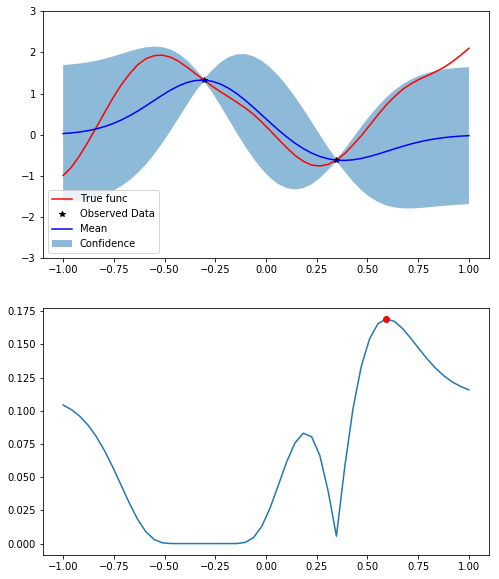

In [5]:
# test ei
y_best = torch.min(train_y)

ei = expected_improvement_wrapper(x, model, y_best)
print(torch.max(ei))
print(x[torch.argmax(ei)])
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy())
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro')
    
x0 = torch.tensor([-1.], requires_grad=True)
num_iters = 100
learning_rate = 0.01
func = lambda x: expected_improvement_wrapper(x, model, y_best)
#x_star, ei = multi_start_optim(func, num_restarts=5)
#ax[1].plot(x_star.item(), -ei.item(), 'bs')

# Define q-EI using reparameterization and Monte Carlo sampling

In [6]:
def qEI(x, gp_model, num_mc_samples=50):
    #model.eval()
    num_points = x.shape[0]
    f_preds = gp_model(x)
    f_mean = f_preds.mean.view(num_points, -1)
    f_covar = f_preds.covariance_matrix
    try:
        L = f_covar.cholesky()
    except: 
        f_covar = f_covar + torch.eye(num_points) * 1e-6
        L = f_covar.cholesky()

    z = torch.randn(x.shape[0], num_mc_samples)

    y = f_mean + L @ z

    y_max, _ = torch.max(y, 0)

    ei = torch.relu(y_max - 1)

    return ei.mean()

test_x = torch.linspace(-bound, bound, 99)
x1, x2 = torch.meshgrid(test_x, test_x)
x1 = x1.reshape(1,-1)[0]
x2 = x2.reshape(1,-1)[0]
qei_values = np.zeros((x1.numel(), x2.numel()))
#for i in range(x1.numel()):
#    for j in range(x2.numel()):
 #       x12 = tensor([x1[i].item(), x2[j].item()])
        #qei_values[i,j] = qEI(x12, model)

In [23]:
class qExpectedImprovement(nn.Module):
    
    def __init__(self, gp_model, y_current_best, num_mc_samples=50):
        super(qExpectedImprovement, self).__init__()
        self.gp_model = gp_model
        self.y_current_best = y_current_best
        self.num_mc_samples = num_mc_samples
        
    def forward(self, x):
        """
        Args:
            x: tensor of shape (n, d)
        Returns:
            expected improvement of locations x
        """
        num_points = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(num_points, -1)
        f_covar = f_preds.covariance_matrix
        try:
            L = f_covar.cholesky()
        except: 
            f_covar = f_covar + torch.eye(num_points) * 1e-6
            L = f_covar.cholesky()

        z = torch.randn(x.shape[0], self.num_mc_samples)
        y = f_mean + L @ z
        y_min, _ = torch.min(y, 0)
        ei = torch.relu(self.y_current_best - y_min)  

        return ei.mean()

    def two_ei_monte_carlo(self, mu, Sigma, y_current_best, num_mc_samples):
        two_d_normal = MultivariateNormal(loc=mu.reshape(torch.Size([2])), 
                                          covariance_matrix=Sigma)
        joint_samples = two_d_normal.sample((num_mc_samples,))
        y_min, _ = torch.min(joint_samples, dim=1)
        improvement = torch.relu(y_current_best -  y_min)
        value = torch.mean(improvement)
        return value
    
    def two_ei_analytic(self, mu, Sigma, y_current_best):
        """
        qEI with q=2, analytic solution
        reference: Ginsbourger et al. (2010), Kriging Is Well-Suited to Parallelize Optimization. 
        https://pdfs.semanticscholar.org/787e/e940ff557f0dcf8d07e9c7ade39d00d5e3df.pdf
        Notations and math follow page 11-14 of the paper
        """
        
        standard_normal = Normal(loc=0, scale=1)
        normpdf = lambda x: torch.exp(standard_normal.log_prob(x))
        normcdf = lambda x: standard_normal.cdf(x)
        
        epsilon = lambda gamma1, alpha1, beta1: (
            alpha1 * 
            normpdf(torch.sqrt(beta1**2/(1+alpha1**2))) /
            torch.sqrt(1+alpha1**2)*
            normcdf(torch.sqrt(1 + alpha1**2)*
                    (gamma1 + alpha1 * beta1 / (1+alpha1**2))) 
            -
            normpdf(gamma1) *
            normcdf(alpha1*gamma1 + beta1)
        )
        
        def delta(m1, m2, sig1, sig2, c12):
            M1 = np.array([m1, m2-m1])
            Gamma = np.array(
                [[sig1**2,       c12 - sig1**2],
                 [c12 - sig1**2, sig2**2 + sig1**2 - 2*c12]]) 
            from scipy.stats import multivariate_normal as mvn
            dist = mvn(mean=M1, cov=Gamma)
            return dist.cdf(np.array([y_current_best,0.]))
        
        def B(i):
            # i=0, j=1 or i=1, j=0
            j = 1 - i
            sig1 = torch.sqrt(Sigma[i,i])  
            sig2 = torch.sqrt(Sigma[j,j])
            m1 = mu[i]
            m2 = mu[j]
            c12 = Sigma[i,j]  # covariance
            rho = c12 / (sig1 * sig2)  # correlation coefficient
            gamma1 = (y_current_best - m1) / sig1
            sqrt_one_minus_rho2 = torch.sqrt(1 - rho.pow(2))
            beta1 = (m1 - m2)/(sig2 * sqrt_one_minus_rho2)
            alpha1 = (sig1 - rho * sig2)/(sig2 * sqrt_one_minus_rho2)
            
            two_ei_value = ((m1 - y_current_best) * delta(m1, m2, sig1, sig2, c12) +
                            sig1 * epsilon(gamma1, alpha1, beta1))
            return two_ei_value
        
        def ei_plus_B(i):
            j = 1 - i
            ei = expected_improvement(mu[i], torch.sqrt(Sigma[i,i]), y_current_best)
            return ei + B(i)
        
        return ei_plus_B(0) + ei_plus_B(1)

        
    def compute_2ei_surface(self, x, analytic=True, use_forward=False):
        num_points = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(num_points, -1)
        f_covar = f_preds.covariance_matrix
        two_ei_surface = np.zeros((num_points, num_points))
        
        if analytic:
            two_ei_func = lambda mu, Sigma: self.two_ei_analytic(mu, Sigma, 
                                                                 self.y_current_best)
        else:
            two_ei_func = lambda mu, Sigma: self.two_ei_monte_carlo(mu, Sigma, 
                                                                    self.y_current_best,
                                                                    self.num_mc_samples)

        for first in range(num_points):
            for second in range(first, num_points):
                
                idx = [first, second]
                mu = f_mean[idx]
                Sigma = f_covar[idx][:,idx]
                try:
                    if not use_forward:
                        two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    else:
                        two_ei_surface[first, second] = self.forward(x[idx].reshape(torch.Size([2,1])))
                except:
                    warnings.warn('covariance matrix singular')
                    Sigma += torch.eye(2) * 1e-6
                    two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    
                two_ei_surface[second, first] = two_ei_surface[first, second]
                
            #sig = torch.sqrt(f_covar[first, first])
            #two_ei_surface[first, first] = expected_improvement(f_mean[first], 
            #                                                    sig, 
            #                                                    self.y_current_best)
        return two_ei_surface
    
print(y_best)
qEI = qExpectedImprovement(model, y_best, 1000000)
test_x = torch.linspace(-bound, bound, 20)
two_ei_surface = qEI.compute_2ei_surface(test_x, analytic=False)
print(two_ei_surface.shape)

two_ei_surface1 = qEI.compute_2ei_surface(test_x, analytic=True)
print(two_ei_surface1.shape)

two_ei_surface2 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True)
print(two_ei_surface2.shape)


tensor(-0.6169)


/home/shalijiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: covariance matrix singular


(20, 20)
(20, 20)
(20, 20)


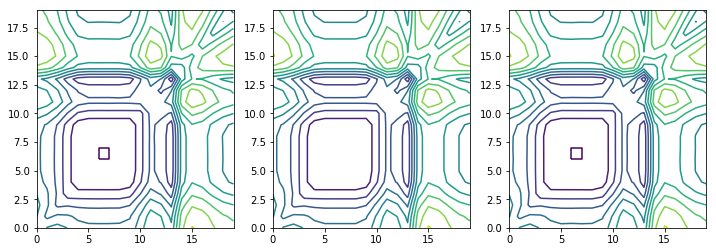

In [24]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].contour(two_ei_surface, 10)
ax[1].contour(two_ei_surface1, 10)
ax[2].contour(two_ei_surface2, 10)


In [32]:
print(qEI.num_mc_samples)
print_num = 3
print(two_ei_surface[:print_num,:print_num])
print(two_ei_surface2[:print_num,:print_num])
print(two_ei_surface1[:print_num,:print_num])
ei = expected_improvement_wrapper(test_x, model, y_best)
print(ei[:print_num].detach().numpy())
print(two_ei_surface.diagonal()[:print_num])
print(two_ei_surface2.diagonal()[:print_num])
print(two_ei_surface1.diagonal()[:print_num])
print(np.linalg.norm(ei.detach().numpy() - two_ei_surface.diagonal()))
print(np.linalg.norm(ei.detach().numpy() - two_ei_surface2.diagonal()))
print(np.linalg.norm(ei.detach().numpy() - two_ei_surface1.diagonal()))

1000000
[[0.10415721 0.12630133 0.13392793]
 [0.12630133 0.0927318  0.10557643]
 [0.13392793 0.10557643 0.06826984]]
[[0.10415766 0.12630828 0.13456643]
 [0.12630828 0.09264673 0.10569794]
 [0.13456643 0.10569794 0.06822618]]
[[0.1045641  0.12704183 0.13440055]
 [0.12704183 0.09247157 0.10574158]
 [0.13440055 0.10574158 0.06815885]]
[0.1044348  0.09236384 0.06813711]
[0.10415721 0.0927318  0.06826984]
[0.10415766 0.09264673 0.06822618]
[0.1045641  0.09247157 0.06815885]
0.001083418500590884
0.0011380867227440649
0.0006010901785579984
